In [1]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_data = np.arctan(grade_data/100)

In [5]:
m = GEKKO()

nt = 101
tm = np.linspace(0,1,nt)
m.time = tm

distance = 1000

# constants
sm = 39.0 #maximal VO2
e0 = 2200 #starting level of energy
e_crit = 0.15 * e0 #critical level of energy, when sigma decreases
g = 9.81 #gravitational constant
mass = 75

# curve coefficients
a = 60 * 50.65
b = 192.86 / 50.65

# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sm * E_data/(e0 * e_crit) + 0.75 * sm * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sm

# slope data to create spline
# x_data = np.linspace(0, distance, 500)
# slope_data = np.array(250*[1/18 * np.pi] + 250 * [-1/18 * np.pi])

x_data = distance_data
slope_data = grade_data

# Variables
v = m.Var(value=0.0, lb=0.0, ub=10.0)
E = m.Var(value=e0, lb=0.0)
x = m.Var(value=0.0)
N = m.Var(value=0.0, lb=0.0)
t = m.Var(value=0.0)

sigma = m.Var(value=sm, lb=0)
sigma_max = m.Var()
slope = m.Var(value=slope_data[0])

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

# FV
tf = m.FV(value=200.0,lb=0.1,ub=300.0)
tf.STATUS = 1

# MV
u = m.MV(value=0,lb=0,ub=12)
u.STATUS = 1

# energy decrease at the end
m.cspline(E, sigma_max, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)


m.Equation(v.dt()==(u - g * m.sin(slope) - v/0.892)*tf)
m.Equation(E.dt()==(sigma - u*v + N * 4 * 4184 * 1/mass)*tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==((1/a * m.exp(-(t * tf + a*b)/a))*tf))
m.Equation(t.dt()==1)
m.Equation(sigma<=sigma_max)

m.Equation((distance-x)*final<=0)

m.Minimize(tf)

m.options.IMODE = 6
m.options.MAX_ITER=15000
m.solve()

print('Final Time: ' + str(tf.value[0]))

tm = tm * tf.value[0]

apm 90.156.80.122_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           13
   Intermediates:            0
   Connections  :            4
   Equations    :            8
   Residuals    :            8
 
 Number of state variables:           2001
 Number of total equations: -         1800
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

  61  9.5133834e+03 4.73e+03 2.55e+13   5.6 9.89e+03    -  2.27e-02 6.00e-02h  1
  62  1.0135531e+04 4.48e+03 2.58e+13  11.3 6.53e+03    -  6.41e-02 5.05e-02h  1
  63  1.1127048e+04 4.26e+03 5.28e+13  12.3 1.36e+04    -  1.28e-01 3.97e-02f  1
  64  1.1127094e+04 4.26e+03 3.49e+13   9.9 2.30e-06  19.2 1.00e+00 1.00e+00s 22
  65r 1.1127094e+04 4.26e+03 1.00e+03   9.8 0.00e+00  18.7 0.00e+00 4.77e-07R 22
  66r 1.1374758e+04 9.38e+03 2.41e+05   3.6 6.14e+06    -  9.90e-01 3.17e-01f  1
  67r 1.3236534e+04 1.58e+04 2.41e+03   3.5 4.20e+06    -  9.90e-01 9.90e-01f  1
  68  1.2723711e+04 1.62e+04 3.01e+02   9.8 7.43e+11    -  6.28e-09 1.13e-09f  1
  69  1.2723702e+04 1.62e+04 7.98e+11   9.8 4.73e-07  18.2 9.90e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.3165871e+04 1.44e+04 5.90e+11   9.1 3.25e+03    -  1.30e-01 1.07e-01h  1
  71  1.3165871e+04 1.44e+04 5.91e+11   8.4 3.84e-06  17.8 9.90e-01 3.81e-06h 19
  72  1.3165560e+04 1.44e+04

 152  5.3660442e+03 2.21e+03 2.42e+16  12.9 5.21e+04    -  2.03e-02 5.95e-03f  1
 153  5.3794979e+03 2.20e+03 2.52e+16  12.2 7.02e-04  19.6 1.00e+00 1.00e+00h  1
 154  5.3976262e+03 2.17e+03 2.42e+16  11.5 2.02e-03  19.1 1.00e+00 4.49e-01h  1
 155  5.4429588e+03 2.12e+03 2.42e+16  10.8 6.07e-03  18.6 1.00e+00 3.73e-01h  1
 156  5.8104258e+03 1.66e+03 2.44e+16  10.1 1.84e-02  18.1 1.00e+00 1.00e+00f  1
 157  6.9797046e+03 2.52e+03 2.59e+16   9.4 5.85e-02  17.6 1.00e+00 1.00e+00h  1
 158  1.2483425e+04 9.63e+03 4.07e+16   8.6 2.75e-01  17.2 1.00e+00 1.00e+00h  1
 159r 1.2483425e+04 9.63e+03 1.00e+03   8.6 0.00e+00  17.6 0.00e+00 4.77e-07R 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r 8.9380192e+03 5.29e+03 5.02e+03   2.4 3.66e+05    -  9.90e-01 9.90e-01f  1
 161  9.1116974e+03 5.29e+03 1.17e+03  11.3 3.30e+13    -  8.76e-10 2.50e-12f  1
 162  9.0696358e+03 5.28e+03 3.53e+13  11.7 6.51e+11    -  1.00e+00 2.57e-10f  2
 163  9.4811953e+03 4.81e+03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r 2.3019738e+04 7.69e+04 8.30e+04   1.0 9.25e-01   3.2 1.00e+00 9.33e-02f  1
 271r 2.3010194e+04 7.68e+04 1.79e+04   1.0 3.16e-01   3.6 1.00e+00 1.00e+00f  1
 272r 2.2980707e+04 7.66e+04 8.96e+03   1.0 7.67e-01   3.2 1.00e+00 5.52e-01f  1
 273r 2.2974813e+04 7.66e+04 6.12e+03   1.0 2.87e-01   3.6 1.00e+00 3.24e-01f  1
 274r 2.2928764e+04 7.63e+04 1.13e+03   1.0 8.60e-01   3.1 1.00e+00 1.00e+00f  1
 275r 2.2925999e+04 7.61e+04 1.12e+03   1.0 3.09e+00   2.6 1.00e+00 1.46e-01f  1
 276r 2.2919275e+04 7.59e+04 1.11e+03   1.0 8.29e+00   2.2 3.07e-01 7.64e-02f  1
 277r 2.2904726e+04 7.52e+04 1.10e+03   1.0 2.76e+01   1.7 2.54e-02 6.86e-02f  1
 278r 2.2705046e+04 7.40e+04 1.09e+03   1.0 8.42e+00   2.1 1.45e-01 3.45e-01f  1
 279r 2.2703430e+04 7.40e+04 1.09e+03   1.0 3.94e-01   3.4 1.00e+00 1.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 2.2684546e+04 7.39e+04

 407r 3.1190937e+04 5.24e+02 6.00e+03   1.0 1.35e+00   2.9 1.00e+00 2.39e-01f  1
 408r 3.1190941e+04 5.23e+02 5.34e+03   1.0 4.08e+00   2.4 1.08e-01 1.06e-01f  1
 409r 3.1189834e+04 5.19e+02 2.23e+03   1.0 1.22e+01   1.9 8.65e-01 1.74e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410r 3.1189407e+04 5.14e+02 2.06e+03   1.0 3.66e+01   1.4 2.15e-01 6.50e-02f  1
 411r 3.1188884e+04 5.14e+02 2.78e+03   1.0 1.71e+00   2.8 1.00e+00 1.09e-01f  1
 412r 3.1187754e+04 5.12e+02 1.02e+03   1.0 5.14e+00   2.3 1.00e+00 1.83e-01f  1
 413r 3.1187194e+04 5.09e+02 1.02e+03   1.0 1.54e+01   1.8 2.88e-01 1.07e-01f  1
 414r 3.1187819e+04 5.06e+02 2.05e+03   1.0 5.79e+00   2.2 6.30e-01 2.95e-01f  1
 415r 3.1187822e+04 5.04e+02 2.26e+03   1.0 1.74e+01   1.8 4.08e-01 6.05e-02f  1
 416r 3.1187627e+04 5.02e+02 1.41e+03   1.0 6.51e+00   2.2 1.00e+00 1.50e-01f  1
 417r 3.1187728e+04 4.98e+02 1.97e+03   1.0 1.95e+01   1.7 5.58e-01 1.19e-01f  1
 418r 3.1189199e+04 4.85e+02

 504  1.2552716e+04 3.03e+04 9.94e+16   3.7 1.14e+03  13.6 1.08e-01 3.93e-04h  1
 505r 1.2552716e+04 3.03e+04 1.00e+03   3.7 0.00e+00  13.2 0.00e+00 3.04e-07R  5
 506r 1.1718760e+04 6.17e+03 1.86e+05   3.8 7.38e+02    -  3.96e-01 9.10e-02f  1
 507r 1.1987766e+04 1.73e+03 1.08e+05   3.6 1.40e+02    -  9.90e-01 5.34e-01f  1
 508  1.2118815e+04 1.73e+03 1.91e+07   6.4 1.28e+08    -  9.90e-01 6.74e-07f  2
 509  1.1849192e+04 1.72e+03 1.53e+11  10.3 9.20e+06    -  1.00e+00 1.47e-04f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.2773976e+04 1.23e+03 3.06e+11   4.3 1.20e+03    -  2.83e-01 2.19e-01h  1
 511  1.4816986e+04 9.27e+02 1.48e+18   4.2 8.11e+02  12.7 4.36e-03 3.57e-01h  1
 512  1.4865793e+04 9.21e+02 1.47e+18  10.4 5.04e+02  13.1 1.00e+00 7.12e-03h  1
 513  1.4869772e+04 9.20e+02 1.46e+18  10.7 5.02e+02  12.6 1.00e+00 5.80e-04h  1
 514  2.6908667e+04 5.26e+02 1.14e+19  10.7 4.88e+02  13.1 1.93e-01 9.90e-01H  1
 515r 2.6908667e+04 5.26e+02

 596  2.9056485e+04 3.48e+00 3.36e+14   8.3 1.63e+01  11.9 1.00e+00 1.00e+00h  1
 597  2.8895000e+04 8.31e+01 5.56e+14   7.2 8.07e-03  16.8 1.00e+00 1.00e+00f  1
 598r 2.8895000e+04 8.31e+01 1.00e+03   7.1 0.00e+00  17.3 0.00e+00 4.77e-07R 22
 599r 2.9198664e+04 6.85e+02 4.92e+01   1.0 1.25e+04    -  9.86e-01 9.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.7746426e+04 7.26e+02 3.34e+04   7.1 1.67e+09    -  2.72e-05 9.48e-08f  2
 601  2.8120378e+04 2.78e+03 7.17e+11   9.9 1.54e+10    -  9.90e-01 5.80e-08f  2
 602  2.8145577e+04 2.78e+03 4.76e+13  11.7 2.47e+04    -  1.00e+00 1.40e-03f  6
 603  2.8574665e+04 1.28e+03 2.34e+12  11.0 3.51e+02    -  6.91e-01 9.90e-01h  1
 604  2.8574958e+04 1.28e+03 2.40e+13  10.3 3.91e-04  16.8 1.00e+00 1.00e+00f  1
 605  2.8576001e+04 1.27e+03 2.56e+13   9.6 1.25e-03  16.3 1.00e+00 1.00e+00s 22
 606  2.8576803e+04 1.26e+03 5.36e+12   8.9 7.87e-04  15.8 1.00e+00 2.31e-01h  2
 607  2.8581703e+04 1.26e+03

 689  3.0080951e+04 3.50e-01 7.00e-02 -11.0 4.29e+00  -1.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  2.9758982e+04 3.03e+00 6.85e-02 -11.0 1.26e+01  -2.3 1.00e+00 1.00e+00f  1
 691  2.8866893e+04 2.44e+01 8.38e-02 -11.0 3.55e+01  -2.7 1.00e+00 1.00e+00f  1
 692  2.7719296e+04 5.58e+01 1.75e-01  -9.0 9.10e+01  -3.2 1.00e+00 5.29e-01f  1
 693  2.7707823e+04 5.56e+01 9.76e+00  -7.0 1.98e+02  -3.7 1.00e+00 2.51e-03h  1
 694  2.7707801e+04 5.56e+01 9.83e+02  -5.0 1.18e+02  -3.3 1.00e+00 8.20e-06h  1
 695  2.6139062e+04 1.08e+02 1.18e+03  -4.7 2.06e+02  -3.7 9.85e-01 3.29e-01f  1
 696  2.6122749e+04 1.07e+02 1.73e+05  -2.8 3.58e+02  -4.2 1.00e+00 2.08e-03h  1
 697  2.4832963e+04 1.28e+02 1.32e+06  -1.8 1.23e+03  -4.7 1.00e+00 1.21e-01f  1
 698  2.4781255e+04 1.26e+02 3.60e+05  -2.6 2.95e+02  -4.3 7.74e-01 2.02e-02h  1
 699  2.4235003e+04 1.22e+02 3.47e+05  -2.2 6.63e+02  -4.8 1.00e+00 9.34e-02h  1
iter    objective    inf_pr 

Overall NLP error.......:   2.7249999443958613e-07    5.4499998887917226e-05


Number of objective function evaluations             = 1479
Number of objective gradient evaluations             = 464
Number of equality constraint evaluations            = 1480
Number of inequality constraint evaluations          = 1480
Number of equality constraint Jacobian evaluations   = 804
Number of inequality constraint Jacobian evaluations = 804
Number of Lagrangian Hessian evaluations             = 783
Total CPU secs in IPOPT (w/o function evaluations)   =     98.389
Total CPU secs in NLP function evaluations           =     12.554

EXIT: Optimal Solution Found.
 
 The solution was found.
 
 The final value of the objective function is    20115.6174743765     
 
 ---------------------------------------------------
 Solver         :  IPOPT (v3.12)
 Solution time  :    111.923999999999      sec
 Objective      :    20115.6174743765     
 Successful solution
 ------------------------------------------

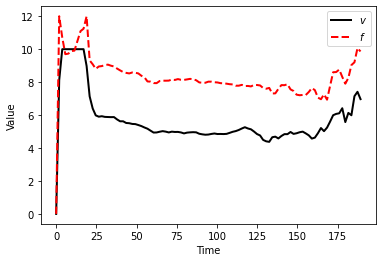

In [6]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

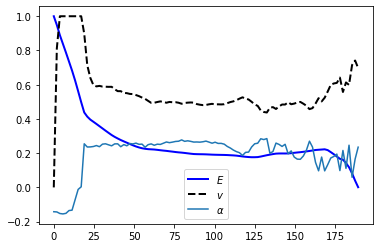

In [10]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()